In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import numpy as np

In [3]:
import math        #import needed modules
#import pyaudio     #sudo apt-get install python-pyaudioPyAudio = pyaudio.PyAudio     #initialize pyaudio
BITRATE = 3000     #number of frames per second/frameset.
FREQUENCY = 1000     #Hz, waves per second, 261.63=C4-note.
LENGTH = 1    #seconds to play soundi
if FREQUENCY > BITRATE:
  BITRATE = FREQUENCY+100
NUMBEROFFRAMES = int(BITRATE * LENGTH)
RESTFRAMES = NUMBEROFFRAMES % BITRATE
WAVEDATA = [] #generating waves
for x in range(NUMBEROFFRAMES):
    temp = int(math.sin(x/((BITRATE/FREQUENCY)/math.pi))*127+128)
    #temp += int(math.sin(2*x/((BITRATE/FREQUENCY)/math.pi))*127+128)
    #temp += 10*int(math.sin(0.1*x/((BITRATE/FREQUENCY)/math.pi))*127+128)
    WAVEDATA.append(temp)
WAVEDATA = (np.array(WAVEDATA)/np.array(WAVEDATA).max()) -0.5
WAVEDATA = WAVEDATA[:1000]

c:\Users\snung\miniconda3\envs\myenv\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1000
  warnings.warn(


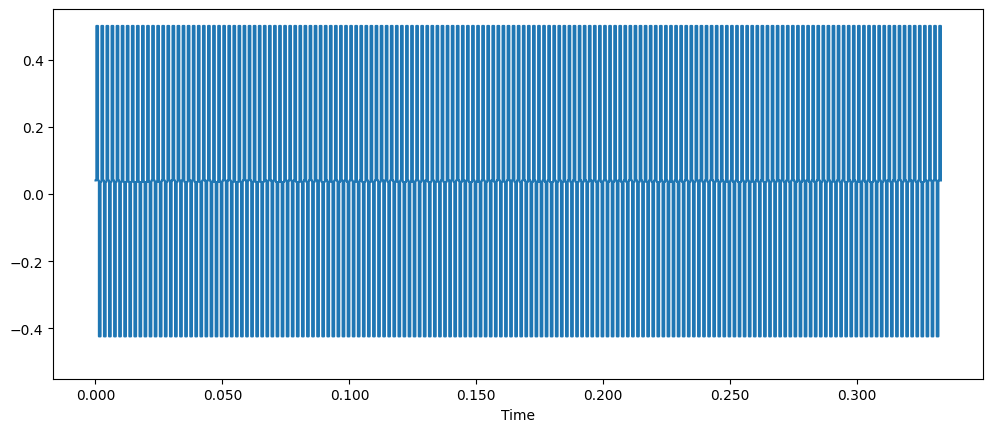

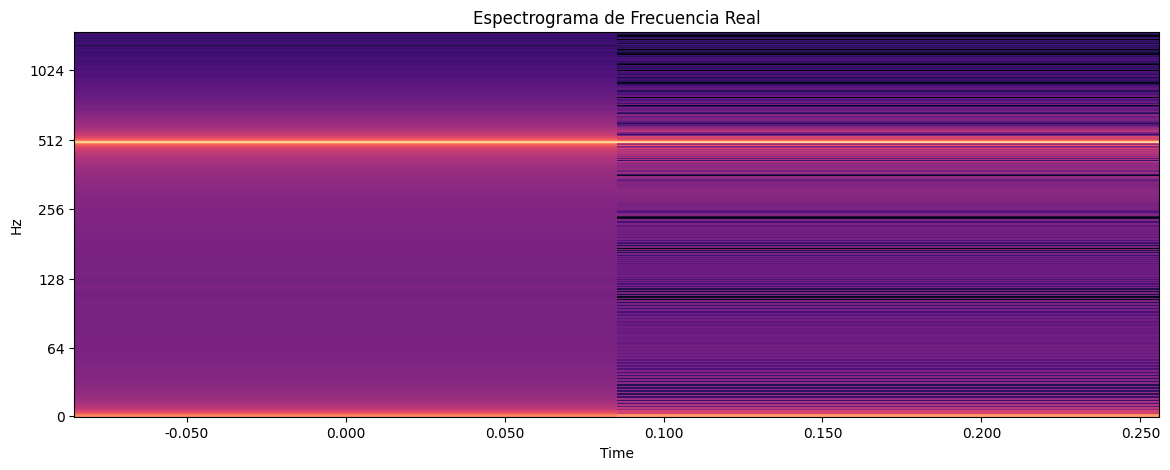

In [4]:
import librosa
from IPython.display import Audio
plt.figure().set_figwidth(12)
librosa.display.waveshow(WAVEDATA, sr=BITRATE)
# Perform a Short-Time Fourier Transform (STFT)
D = librosa.stft(WAVEDATA)
# Convert the complex-valued result to magnitude
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=BITRATE, x_axis='time', y_axis='log')
# plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Frecuencia Real')
plt.show()
Audio(data=WAVEDATA , rate=BITRATE)


In [5]:
class DataTransformer(torch.utils.data.Dataset):
    def __init__(self, wave_data):
        self.wave_data = wave_data

    def __len__(self):
        return 20000

    def __getitem__(self, idx):
        #x = np.random.normal(size=BITRATE, scale=0.1)
        x = self.wave_data
        # x = np.clip(x, -1, 1)
        x= (torch.Tensor(x) - 0.5) / 0.5
                        # .reshape((1, BITRATE)))
        x = torch.Tensor(x)
        return x

data = DataTransformer(WAVEDATA)

In [6]:
from torch.utils.data import DataLoader
BATCH_SIZE = 2
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [8]:
next(iter(dataloader)).shape

torch.Size([2, 1000])

In [29]:
# h = next(iter(dataloader)).numpy()[0]
# plt.figure().set_figwidth(12)
# librosa.display.waveshow(h, sr=BITRATE)
# # Perform a Short-Time Fourier Transform (STFT)
# D = librosa.stft(h)
# # Convert the complex-valued result to magnitude
# S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
# # Display the spectrogram
# plt.figure(figsize=(14, 5))
# librosa.display.specshow(S_db, sr=BITRATE, x_axis='time', y_axis='log')
# # plt.colorbar(format='%+2.0f dB')
# plt.title('Espectrograma de Frecuencia Real')
# plt.show()
# Audio(data=h , rate=BITRATE)


In [30]:
class VAE(nn.Module):
    def __init__(self, in_out_dim, latent_dim):
        super(VAE, self).__init__()

        self.latent_dim = latent_dim
        # Encoder
        self.fc1 = nn.Linear(in_out_dim, 400)  # Input (flattened image) to hidden
        self.fc2 = nn.Linear(400, 400)  # Input (flattened image) to hidden
        self.fc21 = nn.Linear(400, latent_dim)  # Hidden to mean
        self.fc22 = nn.Linear(400, latent_dim)  # Hidden to log-variance

        # Decoder
        self.fc3 = nn.Linear(latent_dim, 400)  # Latent to hidden
        self.fc31 = nn.Linear(400, 400)  # Latent to hidden

        self.fc4 = nn.Linear(400, in_out_dim)  # Hidden to output (reconstruction)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc21(h2), self.fc22(h2)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)  # Sample from standard normal distribution
        return eps * std + mu

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc31(h3))
        return torch.sigmoid(self.fc4(h4))  # Sigmoid for image pixel values

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
device

'cpu'

In [32]:
BATCH_SIZE = 1
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


model = VAE(in_out_dim=1000, latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(num_epochs):
    for epoch in range(num_epochs):
        for step, batch in enumerate(dataloader):
            batch = batch.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(batch)
            loss = loss_function(recon_batch, batch, mu, logvar)
            loss.backward()
            optimizer.step()
            if epoch % 5 == 0 and step == 0:
                print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")

In [36]:
train(5)

RuntimeError: all elements of target should be between 0 and 1

In [16]:
def sample(num_samples):
    with torch.no_grad():
        z = torch.randn(num_samples, model.latent_dim).to(device)
        samples = model.decode(z)

    return samples

In [21]:
samples

tensor([[0.5244, 0.7477, 0.7399,  ..., 0.7539, 0.7512, 0.5170],
        [0.5195, 0.7468, 0.7591,  ..., 0.7457, 0.7621, 0.5200],
        [0.5245, 0.7487, 0.7436,  ..., 0.7477, 0.7538, 0.5203],
        ...,
        [0.5203, 0.7520, 0.7419,  ..., 0.7500, 0.7468, 0.5210],
        [0.5257, 0.7465, 0.7532,  ..., 0.7497, 0.7499, 0.5192],
        [0.5206, 0.7509, 0.7453,  ..., 0.7502, 0.7452, 0.5199]])

In [22]:
import soundfile as sf

samples = sample(10)
sr = BITRATE
for n, s in enumerate(samples):
    to_save_audio = sf.write(f'../data/generated/BOAFAB/gen_{n}.wav', s, sr)

In [37]:
h = sample(1).cpu().numpy()[0]
plt.figure().set_figwidth(12)
librosa.display.waveshow(h, sr=BITRATE)
# Perform a Short-Time Fourier Transform (STFT)
D = librosa.stft(h)
# Convert the complex-valued result to magnitude
S_db = librosa.amplitude_to_db(abs(D), ref=np.max)
# Display the spectrogram
plt.figure(figsize=(14, 5))
librosa.display.specshow(S_db, sr=BITRATE, x_axis='time', y_axis='log')
# plt.colorbar(format='%+2.0f dB')
plt.title('Espectrograma de Frecuencia Real')
plt.show()
Audio(data=h , rate=BITRATE)

NameError: name 'sample' is not defined